<a href="https://colab.research.google.com/github/huang-jiaming/ece421/blob/main/Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

# Load the data
def load_data():
    with np.load('/content/gdrive/My Drive/ECE421/Assignment_2/notMNIST.npz') as data:
        data, targets = data["images"], data["labels"]
        
        np.random.seed(521)
        rand_idx = np.arange(len(data))
        np.random.shuffle(rand_idx)
        
        data = data[rand_idx] / 255.0
        targets = targets[rand_idx].astype(int)
        
        train_data, train_target = data[:10000], targets[:10000]
        valid_data, valid_target = data[10000:16000], targets[10000:16000]
        test_data, test_target = data[16000:], targets[16000:]
    return train_data, valid_data, test_data, train_target, valid_target, test_target


def convert_onehot(train_target, valid_target, test_target):
    new_train = np.zeros((train_target.shape[0], 10))
    new_valid = np.zeros((valid_target.shape[0], 10))
    new_test = np.zeros((test_target.shape[0], 10))

    for item in range(0, train_target.shape[0]):
        new_train[item][train_target[item]] = 1
    for item in range(0, valid_target.shape[0]):
        new_valid[item][valid_target[item]] = 1
    for item in range(0, test_target.shape[0]):
        new_test[item][test_target[item]] = 1
    return new_train, new_valid, new_test



def shuffle(data, target):
    np.random.seed(421)
    rand_idx = np.random.permutation(len(data))
    return data[rand_idx], target[rand_idx]


# Implementation of a neural network using only Numpy - trained using gradient descent with momentum
def relu(x):
    return np.maximum(x, 0)

def softmax(x):
    x = x - x.max(axis = 1, keepdims = True) #prevents overflow
    return np.exp(x)/(np.exp(x).sum(axis = 1, keepdims = True))

def compute_layer(x, w, b):
    return np.matmul(x, w) + b

def average_ce(target, prediction):
    prediction[prediction == 0] = 0.00000000000001 #prevents divide by zero
    return -np.sum(np.multiply(target, np.log(prediction))) / target.shape[0]

def grad_ce(target, logits):
    return (softmax(logits) - target) #prediction - target

def backpropagation(prediction, target, o, wh, wo, x, b):
    dwo = np.matmul(np.transpose(relu(o)), (prediction - target)/target.shape[0]) #average
    ones = np.ones((1, target.shape[0])) #initialize ones
    dbo = np.matmul(ones, (prediction - target)/target.shape[0]) #average
    o[o >= 0] = 1
    o[o < 0] = 0
    dwh = np.matmul(np.transpose(x), o * np.matmul((prediction - target)/target.shape[0], np.transpose(wo))) #average
    dbh = np.matmul(ones, o * np.matmul((prediction - target)/target.shape[0], np.transpose(wo))) #average
    return dwo, dbo, dwh, dbh

Mounted at /content/gdrive


In [4]:
def learning():
    #data cleaning
    train_data, valid_data, test_data, train_target, valid_target, test_target = load_data()
    train_data = train_data.reshape(np.shape(train_data)[0], np.shape(train_data)[1]*np.shape(train_data)[2])
    valid_data = valid_data.reshape(np.shape(valid_data)[0], np.shape(valid_data)[1]*np.shape(valid_data)[2])
    test_data = test_data.reshape(np.shape(test_data)[0], np.shape(test_data)[1]*np.shape(test_data)[2])
    new_train, new_valid, new_test = convert_onehot(train_target, valid_target, test_target)

    #initializations
    epoch = 200
    H = 1000
    F = train_data.shape[1]
    K = 10
    gamma = 0.9
    alpha = 0.1 #without average use 0.1/target.shape[0] scaling
    wo = np.random.normal(0, np.sqrt(2/(H + 10)), (H, 10)) #variance of 2/(units in + units out), zero-mean Gaussians
    wh = np.random.normal(0, np.sqrt(2/(F + H)), (F, H))
    bo = np.zeros((1, 10)) #bias to zero
    bh = np.zeros((1, H))
    train_loss, train_acc, valid_loss, valid_acc = ([] for idx in range(4))

    vwh = np.full((F, H), 1e-5)
    vwo = np.full((H, 10), 1e-5)
    vbh = np.full((1, H), 1e-5)
    vbo = np.full((1, 10), 1e-5)

    for i in range(epoch):
        o = compute_layer(train_data, wh, bh)
        h = relu(o)
        logits = compute_layer(h, wo, bo)
        prediction = softmax(logits)
        train_loss.append(average_ce(new_train, prediction))
        compare = np.equal(np.argmax(prediction, axis = 1), np.argmax(new_train, axis = 1))
        train_acc.append(np.sum((compare==True))/(train_data.shape[0]))

        #back propagation
        dwo, dbo, dwh, dbh = backpropagation(prediction, new_train, o, wh, wo, train_data, bh)

        h_valid = relu(compute_layer(valid_data, wh, bh))
        logits_valid = compute_layer(h_valid, wo, bo)
        prediction_valid = softmax(logits_valid)
        valid_loss.append(average_ce(new_valid, prediction_valid))
        compare_valid = np.equal(np.argmax(prediction_valid, axis = 1), np.argmax(new_valid, axis = 1))
        valid_acc.append(np.sum((compare_valid==True))/(valid_data.shape[0]))

        #update rule
        vwh = gamma * vwh + alpha * dwh
        vwo = gamma * vwo + alpha * dwo
        vbh = gamma * vbh + alpha * dbh
        vbo = gamma * vbo + alpha * dbo
        wo = wo - vwo
        wh = wh - vwh
        bo = bo - vbo
        bh = bh - vbh

    plt.title('Training and Validation Loss')  
    plt.ylabel('Loss')
    plt.xlabel('Epochs')   
    plt.plot(range(epoch), train_loss, 'r', range(epoch), valid_loss, 'b')  
    plt.legend(["Training Loss" ,"Validation Loss"], loc = 'best')
    plt.show()

    plt.title('Training and Validation Accuracy')  
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')   
    plt.plot(range(epoch), train_acc, 'r', range(epoch), valid_acc, 'b')  
    plt.legend(["Training Accuracy" ,"Validation Accuracy"], loc = 'best')
    plt.show()

    print("Final Training Accuracy: ", train_acc[199])
    print("Final Validation Accuracy: ", valid_acc[199])


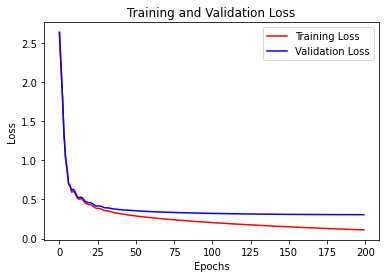

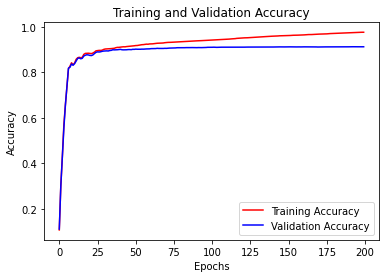

Final Training Accuracy:  0.9768
Final Validation Accuracy:  0.9128333333333334


In [5]:
learning()